In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np
from pydeseq2.preprocessing import deseq2_norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.io import mmread
from scipy.stats import kendalltau

In [3]:
def TPM_function(bambu_rpk):
    
    summation = sum(bambu_rpk)
    
    if summation > 0: 
        bambu_ScaleFactor = sum(bambu_rpk) / 1e6
        bambu_tpm = bambu_rpk / bambu_ScaleFactor
        return bambu_tpm
    else:
        return bambu_rpk

In [4]:
def spearman_count(quant_dir_ont, quant_dir_pacbio):
    

    d = ["directRNA", "directcDNA", "SQ2", "Revio"]
    data_dict = {
    "directRNA": ("directRNA/Hct116_31", quant_dir_ont),
    "directcDNA": ("directcDNA/Hct116_32", quant_dir_ont),
    "SQ2": ("PacBio_kinnex/SQ2", quant_dir_pacbio),
    "Revio": ("PacBio_kinnex/Revio", quant_dir_pacbio)
    }
    shr_list = ["Hct116_31", "Hct116_31", "repA_1", "repA_1"]
    t = {"directRNA":{}, "directcDNA":{}, "SQ2": {}, "Revio":{}}
    threshold_values = {"directRNA":{}, "directcDNA":{}, "SQ2": {}, "Revio":{}}
    
    for (data_key, (data_type, path)), shr_val in zip(data_dict.items(), shr_list):
        shr = pd.read_csv(f'{path}/short_read/{shr_val}/quant.sf', sep="\t")
        shr.columns = shr.columns.str.upper()
        shr.rename(columns={shr.columns[3]: "SHORT_READ"}, inplace=True)
        
        #======================================================================================================
        #read in all synthetic transcripts in Hct116 dataset
        all_txps = pd.read_csv("/mnt/scratch2/zahra/exp_quant_time/all_transcripts_name.csv", sep="\t", header=None)
        all_txps.columns = ["NAME"]
        #======================================================================================================

        merged_shr = pd.merge(shr, all_txps, on='NAME')
        
        #======================================================================================================
        #read in all synthetic transcripts in Hct116 dataset
        synthetic = pd.read_csv("/mnt/scratch2/zahra/exp_quant_time/synthetic_txp_names.csv", sep="\t", header=None)
        synthetic.columns = ["NAME"]
        #======================================================================================================
        
        #choose the transcripts with the lower infRV values (threshold valus is the mean(infRVs))
        infRV = pd.read_csv(f'{path}/short_read/{shr_val}/aux_info/bootstrap/txp_infRV.csv', sep="\t")
        infRV["infRV"] = np.log(infRV["infRV"])
        infRV = infRV[~infRV["Txp"].isin(synthetic["NAME"])]
        stats = infRV['infRV'].describe()
        values = [stats['min'], stats['25%'], stats['50%'], stats['75%'], stats['max']]
        threshold_values[data_key] = sorted(set(values))
        for i in range(len(threshold_values[data_key])):
            mean_value = threshold_values[data_key][i]
            if i == 0:
                infRV_txps = infRV[infRV["infRV"] <= mean_value]
            else:
                infRV_txps = infRV[(infRV["infRV"] > threshold_values[data_key][i - 1]) & (infRV["infRV"] <= mean_value)]
            t[data_key][mean_value] = pd.merge(infRV_txps, merged_shr, left_on="Txp", right_on="NAME", how="left")
            t[data_key][mean_value]['SHORT_READ'] = TPM_function(t[data_key][mean_value]['SHORT_READ'])
        threshold_values[data_key] = [round(val, 1) for val in threshold_values[data_key]] 
        t[data_key] = {round(key, 1): value for key, value in t[data_key].items()} 
            
    
    
    
    #read in the count files   
    oarfish_align_cov = {k: {} for k in d}
    oarfish_align_nocov = {k: {} for k in d}
    NanoCount = {k: {} for k in d}
    bambu = {k: {} for k in d}
    kallisto = {k: {} for k in d}
    isoquant = {k: {} for k in d}
    espresso = {k: {} for k in d}
    transigner = {k: {} for k in d}
    
    
    for v, (k, quant_dir) in data_dict.items():
        oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{k}/out_cov.quant", sep="\t")
        oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_align_quant/{k}/out_nocov.quant", sep="\t")
        #oarfish_align_cov[v] = pd.read_csv(f"{quant_dir}/oarfish_raw_logistic_quant/{k}/cov.quant", sep="\t")
        #oarfish_align_nocov[v] = pd.read_csv(f"{quant_dir}/oarfish_raw_logistic_quant/{k}/nocov.quant", sep="\t")
        ##########################################################################################
        NanoCount[v] = pd.read_csv(f"{quant_dir}/NanoCount_quant/{k}/isoform_expression_estimates", sep="\t")
        NanoCount[v].rename(columns={NanoCount[v].columns[2]: "num_reads"}, inplace=True)
        NanoCount[v]['transcript_name'] = NanoCount[v]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount[v] = NanoCount[v].groupby(NanoCount[v]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        bambu[v] = pd.read_csv(f"{quant_dir}/bambu_quant/{k}/counts_transcript.txt", sep="\t")
        bambu[v].rename(columns={bambu[v].columns[2]: "num_reads"}, inplace=True)
        bambu[v]['TXNAME'] = bambu[v]['TXNAME'].apply(lambda x: x.split('.')[0])
        bambu[v] = bambu[v].groupby(bambu[v]['TXNAME'])['num_reads'].sum().reset_index()
        ###########################################################################################
        kallisto[v] = pd.read_csv(f'{quant_dir}/lr-kallisto/{k}/bus_quant_tcc.tsv', sep='\t')
        kallisto[v].rename(columns={kallisto[v].columns[1]: "num_reads"}, inplace=True)
        kallisto[v]['transcript_id'] = kallisto[v]['transcript_id'].apply(lambda x: x.split('.')[0])
        kallisto[v] = kallisto[v].groupby(kallisto[v]['transcript_id'])['num_reads'].sum().reset_index()
        ###########################################################################################
        if (v != "SQ2") & (v != "Revio"):
            espresso[v] = pd.read_csv(f"{quant_dir}/espresso_quant/{k}/sam_sorted_N2_R0_abundance.esp", sep="\t")
            espresso[v].rename(columns={espresso[v].columns[3]: "num_reads"}, inplace=True)
            espresso[v]['transcript_ID'] = espresso[v]['transcript_ID'].apply(lambda x: x.split('.')[0])
            espresso[v] = espresso[v].groupby(espresso[v]['transcript_ID'])['num_reads'].sum().reset_index()
        ###########################################################################################
        transigner[v] = pd.read_csv(f"{quant_dir}/transigner_quant/{k}/abundances.tsv", sep="\t", header=None)
        transigner[v].columns = ['Txp', 'abundance', 'num_reads']
        transigner[v].rename(columns={transigner[v].columns[2]: "num_reads"}, inplace=True)
        transigner[v]['Txp'] = transigner[v]['Txp'].apply(lambda x: x.split('.')[0])
        transigner[v] = transigner[v].groupby(transigner[v]['Txp'])['num_reads'].sum().reset_index()
        ###########################################################################################
        isoquant[v] = pd.read_csv(f"{quant_dir}/IsoQuant_quant/{k}/OUT/OUT.transcript_counts.tsv", sep="\t")
        isoquant[v]['#feature_id'] = isoquant[v]['#feature_id'].str.split('.').str[0]
        isoquant[v].rename(columns={isoquant[v].columns[1]: "num_reads"}, inplace=True)
        isoquant[v] = isoquant[v].groupby(isoquant[v]['#feature_id'])['num_reads'].sum().reset_index()

        
    #obtain the TPM of the counts
    for v in d:
        oarfish_align_cov[v]['num_reads'] = TPM_function(oarfish_align_cov[v]['num_reads'])
        oarfish_align_nocov[v]['num_reads'] = TPM_function(oarfish_align_nocov[v]['num_reads'])
        NanoCount[v]['num_reads'] = TPM_function(NanoCount[v]['num_reads'])
        bambu[v]['num_reads'] = TPM_function(bambu[v]['num_reads'])
        kallisto[v]['num_reads'] = TPM_function(kallisto[v]['num_reads'])
        isoquant[v]['num_reads'] = TPM_function(isoquant[v]['num_reads'])
        if (v != "SQ2") & (v != "Revio"):
            espresso[v]['num_reads'] = TPM_function(espresso[v]['num_reads'])
        transigner[v]['num_reads'] = TPM_function(transigner[v]['num_reads']) 

    m = {k: {} for k in d}
    for v in d:
        m[v] = {}
        for mean_value in threshold_values[v]:
            #print(v)
            m[v][mean_value] = pd.merge(oarfish_align_cov[v], t[v][mean_value], left_on="tname", right_on="NAME", how="right", suffixes=('_align_cov', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "oarfish (cov)"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(oarfish_align_nocov[v], m[v][mean_value], left_on="tname", right_on="NAME", how="right", suffixes=('_align_nocov', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "oarfish (nocov)"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(NanoCount[v], m[v][mean_value], left_on="transcript_name", right_on="NAME", how="right", suffixes=('_NanoCount', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "NanoCount"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(bambu[v], m[v][mean_value], left_on="TXNAME", right_on="NAME", how="right", suffixes=('_bambu', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "bambu"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(kallisto[v], m[v][mean_value], left_on="transcript_id", right_on="NAME", how="right", suffixes=('_kallisto', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "lr-kallisto"})
            #print(len(m[v]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            if (v != "SQ2") & (v != "Revio"):
                m[v][mean_value] = pd.merge(espresso[v], m[v][mean_value], left_on="transcript_ID", right_on="NAME", how="right", suffixes=('_espresso', ''))
                m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "ESPRESSO"})
                #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(transigner[v], m[v][mean_value], left_on="Txp", right_on="NAME", how="right", suffixes=('_transigner', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "TranSigner"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = pd.merge(isoquant[v], m[v][mean_value], left_on="#feature_id", right_on="NAME", how="right", suffixes=('_isoquant', ''))
            m[v][mean_value] = m[v][mean_value].rename(columns={"num_reads" : "IsoQuant"})
            #print(len(m[v][mean_value]["NAME"]))
            #--------------------------------------------------------------------------------------------------
            m[v][mean_value] = m[v][mean_value].fillna(0)
            #print(len(m[v][mean_value]["NAME"]))

    

    for v in d:
        for mean_value in threshold_values[v]:
            if (v != "SQ2") & (v != "Revio"):
                for j in ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "SHORT_READ"]:
                    m[v][mean_value][j] = TPM_function(m[v][mean_value][j])
            else:
                for j in ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "SHORT_READ"]:
                    m[v][mean_value][j] = TPM_function(m[v][mean_value][j])
    
    
    columns_to_compare_Hct116 = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]
    columns_to_compare_uhrr = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "bambu", "lr-kallisto", "TranSigner", "IsoQuant"]
    epsilon = 1e-10
    
    output = {'spearman': {}, 'pearson': {}, 'CCC': {}, 'Kendall': {}, 'RMSE': {}, 'MARD': {}, 'NRMSE': {}}
    for method in output.keys():
        tmp = {}
        for (k1, v1), columns_to_compare in zip(m.items(), [columns_to_compare_Hct116, columns_to_compare_Hct116, columns_to_compare_uhrr, columns_to_compare_uhrr]):
            tmp[k1] = {}
            for k2, v2 in v1.items():
                mix = "SHORT_READ"
                if method == "spearman":
                    tmp[k1][k2] = v2.loc[:, columns_to_compare + ["SHORT_READ"]].corr(method="spearman")[mix]
                    tmp[k1][k2] = tmp[k1][k2][:-1]
                #---------------------------------------------------------------------------------------
                if method == "pearson":
                    pseudocount = 1.0
                    log2_columns = v2.loc[:, columns_to_compare + ["SHORT_READ"]].apply(lambda x: np.log2(x + pseudocount))
                    tmp[k1][k2] = log2_columns.corr(method="pearson")[mix]
                    tmp[k1][k2] = tmp[k1][k2][:-1]
                #---------------------------------------------------------------------------------------
                if method == "Kendall":
                    Kendall_values = {}
                    for column_name in columns_to_compare:
                        y_true = v2[mix]
                        y_pred = v2[column_name]
                        tau, p_value = kendalltau(y_true, y_pred)
                        Kendall_values[column_name] = tau
                    tmp[k1][k2] = pd.Series(Kendall_values)
                #---------------------------------------------------------------------------------------
                if method == "CCC":
                    pseudocount = 1.0
                    log2_columns = v2.loc[:, columns_to_compare + ["SHORT_READ"]].apply(lambda x: np.log2(x + pseudocount))
                    pearson_corr = log2_columns.corr(method="pearson")[mix]
                
                    ccc_correlation = {}
                    for column_name in columns_to_compare:
                        y_true = log2_columns[mix]
                        y_pred = log2_columns[column_name]
                        #obtain the mean value
                        mean_true = np.mean(y_true)
                        mean_pred = np.mean(y_pred)
                        #obtain the standard deviation
                        std_true = np.std(y_true)
                        std_pred = np.std(y_pred)
                        ccc_correlation[column_name] = (2 * pearson_corr[column_name] * std_true * std_pred) / \
                                                       (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
                    tmp[k1][k2] = pd.Series(ccc_correlation)
                #---------------------------------------------------------------------------------------
                if method == "RMSE":
                    rmse_values = {}
                    for column_name in columns_to_compare:
                        #if y_true.empty or y_pred.empty:
                        #    print(f"Warning: Empty arrays for {mix} or {column_name} for {k1} and {k2}. Skipping RMSE calculation.")
                        #else:
                        #    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                        y_true = v2[mix]
                        y_pred = v2[column_name]
                        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                        rmse_values[column_name] = rmse
                    tmp[k1][k2] = pd.Series(rmse_values)
                #---------------------------------------------------------------------------------------
                if method == "NRMSE":
                    nrmse_values = {}
                    for column_name in columns_to_compare:
                        y_true = v2[mix]
                        y_pred = v2[column_name]
                        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                        range_observed = np.mean(y_true)
                        nrmse_values[column_name] = rmse / range_observed
                    tmp[k1][k2] = pd.Series(nrmse_values)
                #---------------------------------------------------------------------------------------
                if method == "MARD":
                    mard_values = {}
                    for column_name in columns_to_compare:
                        y_true = v2[mix]
                        y_pred = v2[column_name]
                        filtered_y_pred = y_pred
                        filtered_y_true = y_true
                        mard = np.mean(abs((filtered_y_pred - filtered_y_true) / (filtered_y_pred + filtered_y_true + epsilon)))
                        mard_values[column_name] = mard
                    tmp[k1][k2] = pd.Series(mard_values)
                #---------------------------------------------------------------------------------------
    
                #---------------------------------------------------------------------------------------
            output[method][k1] = pd.DataFrame(tmp[k1])
            #output[method][k1] = output[method][k1].reset_index().rename(columns={'index': 'Method'})
    
    return output
    

In [5]:
def plot_function_main(input_tmp, fig_path):

    input_list = {}
    for method, v2 in input_tmp.items():
        input_list[method] = {}
        for dt_type, v3 in v2.items():
            input_list[method][dt_type] = v3.reset_index().rename(columns={'index': 'Threshold'})
    #print(input_list)
    #plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(12, 6))  # Adjusted figure size to accommodate legend
    # Adjust the overall margins of the figure
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)  # Overall figure spacing
    gs = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.9, width_ratios=[100, 1])
    
    ax_legend = fig.add_subplot(gs[:, 1])  # This will be the space for the legend
    ax_legend.axis('off')  # Turn off the axis for the legend
    
    color_palette = plt.get_cmap("tab10").colors[:8]
    marker_palette = ['o', '^', 's', 'p', 'h', '+', 'x', '*', 'o']
    
    # Define consistent color and marker for each v1, v2 pair
    data_styles = {
        "directRNA": {"label": "(a) Hct116 cell-line -- direct RNA sequencing", "color": "royalblue"},
        "SQ2": {"label": "(b) UHRR cell-line -- SQ2-HiFi sequencing", "color": "royalblue"}
    }

    method_styles = {
        "directRNA": {
            'oarfish (cov)': {"marker": marker_palette[0], "color": color_palette[0]},
            'oarfish (nocov)': {"marker": marker_palette[1], "color": color_palette[1]},
            'NanoCount': {"marker": marker_palette[2], "color": color_palette[2]},
            'bambu': {"marker": marker_palette[3], "color": color_palette[3]},
            'lr-kallisto': {"marker": marker_palette[4], "color": color_palette[4]},
            'TranSigner': {"marker": marker_palette[5], "color": color_palette[5]},
            'IsoQuant': {"marker": marker_palette[6], "color": color_palette[6]},
            'ESPRESSO': {"marker": marker_palette[7], "color": color_palette[7]},
        },
        
        "SQ2": {
            'oarfish (cov)': {"marker": marker_palette[0], "color": color_palette[0]},
            'oarfish (nocov)': {"marker": marker_palette[1], "color": color_palette[1]},
            'NanoCount': {"marker": marker_palette[2], "color": color_palette[2]},
            'bambu': {"marker": marker_palette[3], "color": color_palette[3]},
            'lr-kallisto': {"marker": marker_palette[4], "color": color_palette[4]},
            'TranSigner': {"marker": marker_palette[5], "color": color_palette[5]},
            'IsoQuant': {"marker": marker_palette[6], "color": color_palette[6]},
        }
    }
    
    
    metric_values = {
        "spearman": {"label": "Spearman Correlation"}, 
        "pearson": {"label": "Pearson Correlation"}, 
        "MARD": {"label": "MARD"}
    }
    
    handles, labels = [], []
        
        
    
    for data_idx, (data_type, data_label) in enumerate(data_styles.items()):
        
        # Use threshold values as x-axis (convert to string)
        x_values = input_list['spearman'][data_type].columns[1:].tolist()
        x_values_str = ['≤ ' + str(x_values[0])]
        for i in range(1, len(x_values)):
            x_values_str.append(f'({x_values[i - 1]}, {x_values[i]}]')
        
        
        ax = fig.add_subplot(gs[data_idx, 0])
        ax.axis('off')
        ax.set_title(data_label["label"], fontsize=14, fontweight='bold', color=data_label["color"], pad=28)
        
        gs_inner = gs[data_idx, 0].subgridspec(1, 3, wspace=0.2, hspace=0)  # Controls spacing between inner subplots
        
        for metric_idx, (metric, metric_label) in enumerate(metric_values.items()):
            sub_ax = fig.add_subplot(gs_inner[0, metric_idx])
            for method, values in method_styles[data_type].items():
                
                df = input_list[metric][data_type]
                y_values = df[df['Threshold'] == method].iloc[0, 1:].tolist()
                
                if (data_idx == 0) & (metric_idx == 0):
                    l1, = sub_ax.plot(x_values_str, y_values, 
                           marker=values['marker'], ms=6, linestyle='--', lw=1.2, color=values['color'], label=f'{method}')
                    handles.append(l1)
                    labels.append(f'{method}')
                else:
                    sub_ax.plot(x_values_str, y_values, 
                           marker=values['marker'], ms=6, linestyle='--', lw=1.2, color=values['color'], label=f'{method}')
        
                # Customize the plot
                sub_ax.set_xlabel('log10(infRV)', fontsize=13)
                sub_ax.set_ylabel(metric_label["label"], fontsize=13)
                sub_ax.set_title(metric_label["label"], fontsize=13)
                sub_ax.grid(True)
            
                # Customize the x-axis labels with string x_values
                sub_ax.set_xticks(x_values_str)  # Set the x-axis values as strings
                sub_ax.set_xticklabels(x_values_str, rotation=25, fontsize=12, ha='right')

    #=========================================================================================================================================

    # Creating a legend outside the plot area
    ax_legend.legend(handles, labels, loc='center', fontsize=13.5, ncol=1) #, bbox_to_anchor=(0.2, 0.3, 0.5, 0.5))
    
    plt.tight_layout()

    # Save the figure as a JPEG file
    directory = os.path.dirname(fig_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
def plot_function_supp(input_tmp, fig_path):

    input_list = {}
    for method, v2 in input_tmp.items():
        input_list[method] = {}
        for dt_type, v3 in v2.items():
            input_list[method][dt_type] = v3.reset_index().rename(columns={'index': 'Threshold'})
    #print(input_list)
    #plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(12, 10))  # Adjusted figure size to accommodate legend
    # Adjust the overall margins of the figure
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)  # Overall figure spacing
    gs = fig.add_gridspec(3, 1, hspace=1.1,height_ratios=[1000, 1000, 0.000001])
    
    ax_legend = fig.add_subplot(gs[2, :])  # This will be the space for the legend
    ax_legend.axis('off')  # Turn off the axis for the legend
    
    color_palette = plt.get_cmap("tab10").colors[:8]
    marker_palette = ['o', '^', 's', 'p', 'h', '+', 'x', '*', 'o']
    
    # Define consistent color and marker for each v1, v2 pair
    data_styles = {
        "directcDNA": {"label": "(a) Hct116 cell-line -- direct cDNA sequencing", "color": "royalblue"},
        "Revio": {"label": "(b) UHRR cell-line -- Revio-HiFi sequencing", "color": "royalblue"}
    }

    method_styles = {
        "directcDNA": {
            'oarfish (cov)': {"marker": marker_palette[0], "color": color_palette[0]},
            'oarfish (nocov)': {"marker": marker_palette[1], "color": color_palette[1]},
            'NanoCount': {"marker": marker_palette[2], "color": color_palette[2]},
            'bambu': {"marker": marker_palette[3], "color": color_palette[3]},
            'lr-kallisto': {"marker": marker_palette[4], "color": color_palette[4]},
            'TranSigner': {"marker": marker_palette[5], "color": color_palette[5]},
            'IsoQuant': {"marker": marker_palette[6], "color": color_palette[6]},
            'ESPRESSO': {"marker": marker_palette[7], "color": color_palette[7]},
        },
        
        "Revio": {
            'oarfish (cov)': {"marker": marker_palette[0], "color": color_palette[0]},
            'oarfish (nocov)': {"marker": marker_palette[1], "color": color_palette[1]},
            'NanoCount': {"marker": marker_palette[2], "color": color_palette[2]},
            'bambu': {"marker": marker_palette[3], "color": color_palette[3]},
            'lr-kallisto': {"marker": marker_palette[4], "color": color_palette[4]},
            'TranSigner': {"marker": marker_palette[5], "color": color_palette[5]},
            'IsoQuant': {"marker": marker_palette[6], "color": color_palette[6]},
        }
    }
    
    
    metric_values = {
        "spearman": {"label": "Spearman Correlation"}, 
        "pearson": {"label": "Pearson Correlation"}, 
        "MARD": {"label": "MARD"}
    }
    
    handles, labels = [], []
        
        
    
    for data_idx, (data_type, data_label) in enumerate(data_styles.items()):
        
        # Use threshold values as x-axis (convert to string)
        x_values = input_list['spearman'][data_type].columns[1:].tolist()
        x_values_str = ['≤ ' + str(x_values[0])]
        for i in range(1, len(x_values)):
            x_values_str.append(f'({x_values[i - 1]}, {x_values[i]}]')
        
        
        ax = fig.add_subplot(gs[data_idx, :])
        ax.axis('off')
        ax.set_title(data_label["label"], fontsize=16, fontweight='bold', color=data_label["color"], pad=35)
        
        gs_inner = gs[data_idx, :].subgridspec(1, 3, wspace=0.2, hspace=0)  # Controls spacing between inner subplots
        
        for metric_idx, (metric, metric_label) in enumerate(metric_values.items()):
            sub_ax = fig.add_subplot(gs_inner[0, metric_idx])
            for method, values in method_styles[data_type].items():
                
                df = input_list[metric][data_type]
                y_values = df[df['Threshold'] == method].iloc[0, 1:].tolist()
                
                if (data_idx == 0) & (metric_idx == 0):
                    l1, = sub_ax.plot(x_values_str, y_values, 
                           marker=values['marker'], ms=6, linestyle='--', lw=1, color=values['color'], label=f'{method}')
                    handles.append(l1)
                    labels.append(f'{method}')
                else:
                    sub_ax.plot(x_values_str, y_values, 
                           marker=values['marker'], ms=6, linestyle='--', lw=1, color=values['color'], label=f'{method}')
        
                # Customize the plot
                sub_ax.set_xlabel('log10(infRV)', fontsize=12)
                sub_ax.set_ylabel(metric_label["label"], fontsize=12)
                sub_ax.set_title(metric_label["label"], fontsize=12)
                sub_ax.grid(True)
            
                # Customize the x-axis labels with string x_values
                sub_ax.set_xticks(x_values_str)  # Set the x-axis values as strings
                sub_ax.set_xticklabels(x_values_str, rotation=45, fontsize=10, ha='right')

    #=========================================================================================================================================

    # Creating a legend outside the plot area
    ax_legend.legend(handles, labels, loc='center', fontsize=14, ncol=4, bbox_to_anchor=(0.2, 0.3, 0.5, 0.5))
    
    plt.tight_layout()

    # Save the figure as a JPEG file
    directory = os.path.dirname(fig_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


In [7]:
quant_ont = '/mnt/scratch2/zahra/exp_quant_time/Hct116_quant'
quant_pacbio = '/mnt/scratch2/zahra/exp_quant_time/uhrr_quant'

output = {}

output = spearman_count(quant_ont, quant_pacbio)

/mnt/scratch2/zahra/tmp/ipykernel_9981/495261022.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


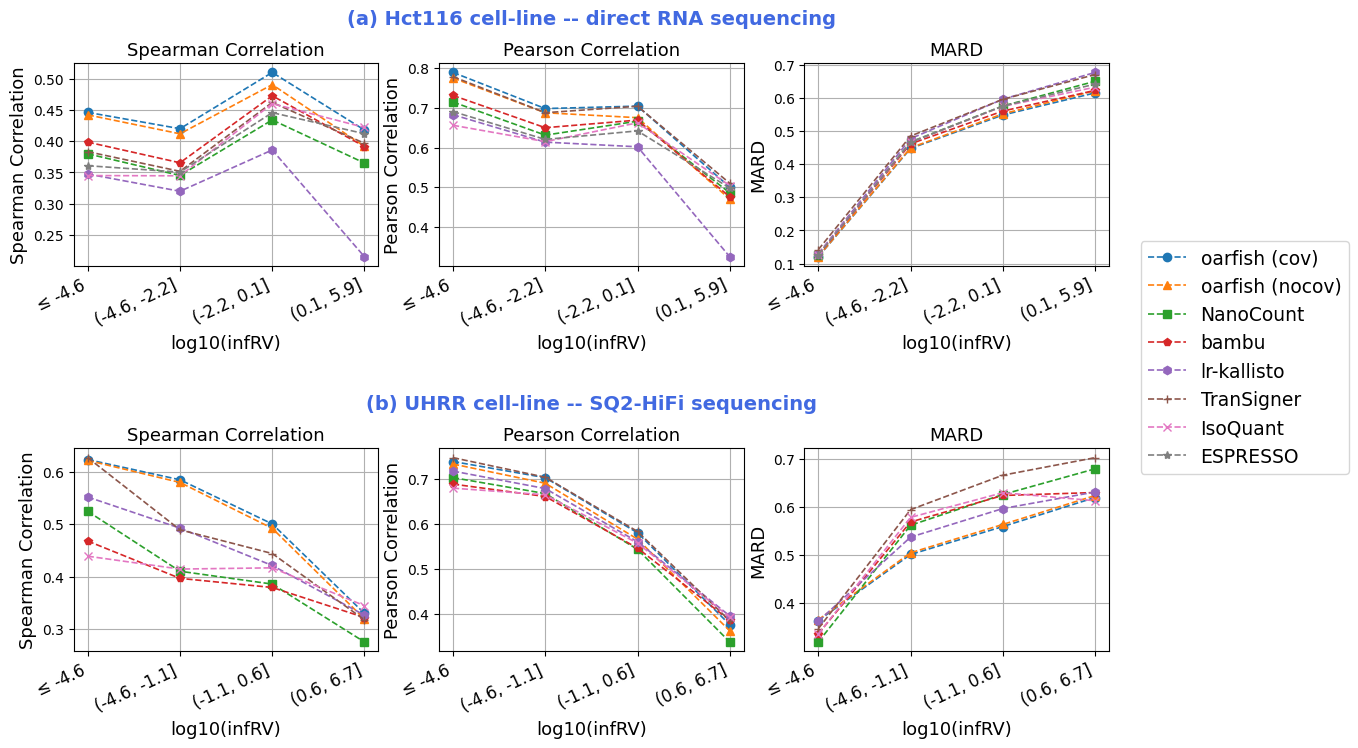

In [8]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/exp_data/drna_SQ2_main.jpg'
plot_function_main(output, fig_path)

/mnt/scratch2/zahra/tmp/ipykernel_9981/592521254.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


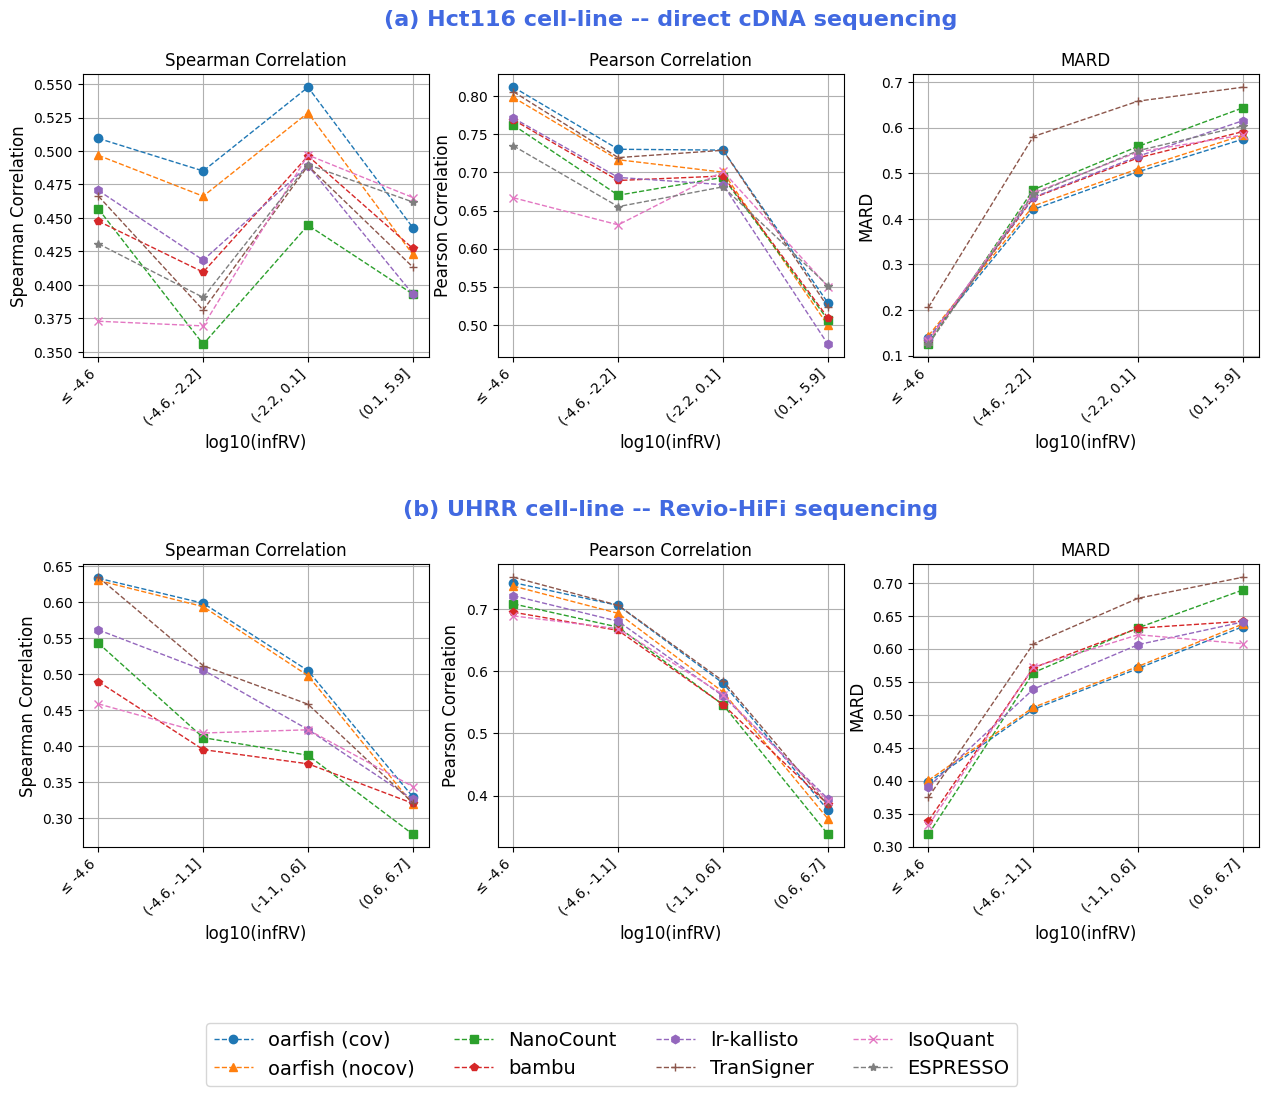

In [9]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/exp_data/cdna_Revio_supp.jpg'
plot_function_supp(output, fig_path)